<h1 style="color:SteelBlue; font-size:200%">Разработка модели для подбора тарифа сотовой связи</h1>

Задача: разработать модель, которая порекомендует для пользователя один из двух тарифов

Заказчик предоставил данные о поведении клиентов, которые уже перешли на эти тарифы. Данные предобработаны.

**Описание данных**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

**Импорт библиотек, функции для проекта**

In [1]:
#pandas для получения и обработки данных
import pandas as pd

#numpy используется в перестановочном тесте
import numpy as np

#именованный кортеж для функций
from collections import namedtuple

#ML
#решающее дерево для классификации
from sklearn.tree import DecisionTreeClassifier
#случайный лес для классификации
from sklearn.ensemble import RandomForestClassifier
#логистическая регрессия
from sklearn.linear_model import LogisticRegression
#для разделения выборки на обучающую, валидационную и тестовую
from sklearn.model_selection import train_test_split
#метрики качества
from sklearn.metrics import classification_report

#графика
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

#для оценки времени работы модели
from datetime import datetime

#для оценки адекватности моделей на базе случайной модели
import random

#для статистического анализа
from scipy import stats

#база для рандом
RND = 271828

In [2]:
#перестановочные статистические тесты 
#написаны мной в другом проекте, поэтому комментарии на англ. языке
def AB_permutation_test(x, y, par='means', iterations=10000):   
    """
    This is a two-sided permutation test for the null hypothesis that 
    2 samples (x=A and y=B) have identical average values or median values 
    or variances.

    No assumption of the distribution's normality needed
    Samples can be of different sizes, independent or dependent.

    1. The test can be verified by a t-test for the means difference:
    
        scipy.stats.ttest_ind(x,y)
        pvalues should be approximately the same

        Note:
            - normal distributions needed for A, B
            - statistics are different, because 
            in t-test statistic = mean(x)-mean(y)/var(x-y) 
            and in this test statistic = abs(mean(x)-mean(y)) without var(x-y) 

    2. The test can be verified by a Fisher distribution for the variances 
    ratio:
    
        scipy.special.fdtrc(dfn, dfd, f)
        dfn = len(x) - 1
        dfd = len(y) - 1
        f = np.var(x) / np.var(y)
        statistics and pvalues should be approximately the same

        Notes: 
            - normal distributions needed for A, B

    Parameters
    ----------
    
    x : array_like
        A sample.
    
    y : array_like
        B sample.
    
    par : str, optional
        Type of test statistic:
        'means': the absolute difference between the means
        statistic = abs(mean(x) - mean(y))
        
        'medians': the absolute difference between the medians
        statistic = abs(median(x) - median(y))
        
        'variances': the ratio of the variances
        if var(x) > var(y)
        statistic = var(x) / var(y)
        if var(x) < var(y)
        statistic = var(y) / var(x)
        
        The default is 'means'.
    
    iterations : integer, optional
        Number of permutations. The default is 1000.

    Returns
    -------
    named tuple (statistic, iterations, pvalue).
    
    statistic: float
        The computed statistic of the test.
        
        'means_difference' = abs(mean(x) - mean(y))
        'medians_difference' = abs(median(x) - median(y))
        'variances_ratio' = var(x) / var(y)

    itertions: int
        Number of permutations  
        
    pvalue: float
        The two-tailed p-value: number of times, when permutations statistics 
        were larger than the original, divided by the number of iterations
   
    """
    k = 0
    size_a = len(x)
    a=np.asarray(x) 
    b=np.asarray(y)
    alldata = np.concatenate((a, b))
    
    if par == 'means':
        statistic = 'means_difference'
        diff = np.mean(a) - np.mean(b)
    elif par == 'medians':
        statistic = 'medians_difference'
        diff = np.median(a) - np.median(b)
    elif par == 'variances':
        statistic = 'variances_ratio'
        var_a = np.var(a, ddof=1)
        var_b = np.var(b, ddof=1)
        var_1 = max(var_a, var_b)
        var_2 = min(var_a, var_b)
        diff = var_1 / var_2
    else:
        return "ERROR. Incorrect 'par' value. Use par='means' or 'medians' or 'variances'."
    
    abs_diff = abs(diff)
  
    for i in range (0, iterations):
        np.random.shuffle(alldata) #перемешиваю
        if par == 'means':
            abs_random_diff = abs( np.mean(alldata[:size_a]) - np.mean(alldata[size_a:]) )
        elif par == 'medians':
            abs_random_diff = abs( np.mean(alldata[:size_a]) - np.mean(alldata[size_a:]) )
        elif par == 'variances':
            abs_random_diff = np.var(alldata[:size_a], ddof=1) / np.var(alldata[size_a:], ddof=1)
        
        k += abs_diff < abs_random_diff
        
    pvalue = k / iterations
       
    ABPermutationResult = namedtuple('AB_PermutationResult', (statistic, 'iterations', 'pvalue'))
    
    return ABPermutationResult(diff, iterations, pvalue)


def ANOVA_permutation_test(*args, iterations=10000):
    
    """

    Parameters
    ----------
    *args : sample1, sample2, …: array_like
        The sample measurements for each group.

    iterations : integer, optional
        Number of permutations. The default is 10000.

    Returns
    -------
    
    statistic: float
        The computed F-value of the test.
        
    iterations : int
        Number of permutations.

    pvalue: float
        The associated p-value: number of times, when permutations statistics 
        were larger than the original, divided by the number of iterations
        
    """
    k = 0
    args = [np.asarray(arg) for arg in args]
    
    alldata = np.concatenate(args)
    mean_alldata = np.mean(alldata)
    
    n_groups = len(args)
    n_alldata = len(alldata)
    
    fbg = n_groups - 1
    fwg = n_alldata - n_groups
    
    SSbg = 0    
    SStotal = np.var(alldata)*n_alldata
    
    size_groups = []
    for arg in args:
        size_groups.append(len(arg))
        SSbg += len(arg)*(mean_alldata - np.mean(arg))**2
    
    SSwg = SStotal - SSbg

    F_orig = (SSbg/fbg) / (SSwg/fwg)
    
    for i in range(0, iterations):
        np.random.shuffle(alldata)
        size_previous = 0
        random_groups = []
        SSbg_random = 0
        
        for size_grp in size_groups:
            random_groups.append(alldata[size_previous : (size_grp+size_previous)])
            size_previous += size_grp
        
        for random_grp in random_groups:
            SSbg_random += len(random_grp)*(mean_alldata - np.mean(random_grp))**2
            
        
        SSwg_random = SStotal - SSbg_random
        F_random = (SSbg_random/fbg) / (SSwg_random/fwg)
        k += F_orig < F_random
    
    pvalue = k / iterations
    
    ANOVAPermutationResult = namedtuple('ANOVA_PermutationResult', ('f_statistic', 'iterations', 'pvalue'))
    
    return ANOVAPermutationResult(F_orig, iterations, pvalue) 

<h1 style="color:SteelBlue; font-size:200%">1. Загрузка, анализ и подготовка данных</h1>

<h2 style="color:DodgerBlue">1.1 Общая информация, оценка данных</h2>

In [3]:
link = 'datasets/megaline/users_behavior.csv'
df = pd.read_csv(link)
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Число звонков и смс можно перевести в int, сделаю это

In [5]:
df.loc[:, 'calls'] = df['calls'].astype(int)
df.loc[:, 'messages'] = df['messages'].astype(int)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null int64
minutes     3214 non-null float64
messages    3214 non-null int64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


In [7]:
print('полных дублей в датасете:', df.duplicated().sum())

полных дублей в датасете: 0


Посмотрю на гистограммах, нет ли выбросов или аномалий.

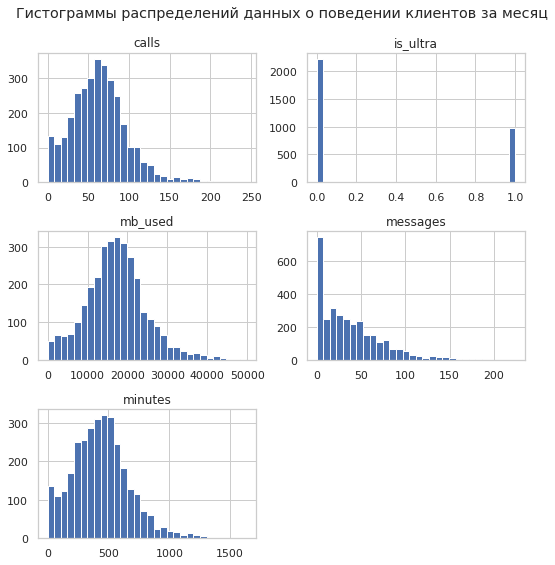

In [8]:
df.hist(figsize=(8,8), bins=30)
plt.suptitle('Гистограммы распределений данных о поведении клиентов за месяц')
plt.tight_layout(rect=(0,0,0.95,0.95))
plt.show()

Выбросов и аномалий не видно. Наблюдения:

- клиентов Smart более чем в 2 раза больше, чем Ultra
- многие клиенты вообще не посылали смс

Проверю, для обоих тарифов характерно отсутствие смс?

In [9]:
df.loc[df.loc[:, 'messages'] == 0, 'is_ultra'].value_counts()

0    307
1    190
Name: is_ultra, dtype: int64

Да, для обоих.

Проверю, нет ли ошибок в продолжительности звонков (когда звонки были, а продолжительность 0)

In [10]:
df.loc[(df.loc[:, 'minutes'] == 0) & (df.loc[:, 'calls'] != 0), 'minutes'].count()

0

Всё в порядке, израсходовано 0 минут, только когда вообще не было звонков.

Проверю, нет ли таких признаков, по которым тарифы не различаются (и которые в модели не принесут пользы). Сравню средние значения признаков для тарифов.
- alpha = 0.05
- H0: средние выборок не различаются (имеющиеся различия можно получить случайно в alpha или большей доле случаев)
- H1: между средними выборок есть значимые различия (имеющиеся различия можно получить случайно только в меньшей, чем alpha доле случаев)

In [11]:
df_ultra = df.loc[df.loc[:, 'is_ultra'] == 1, :].drop(columns='is_ultra')
df_smart = df.loc[df.loc[:, 'is_ultra'] == 0, :].drop(columns='is_ultra')
for feature in df_smart.columns:
    a = df_ultra[feature]
    b = df_smart[feature]
    print(feature)
    print(AB_permutation_test(a, b))

calls
AB_PermutationResult(means_difference=14.929456882397012, iterations=10000, pvalue=0.0)
minutes
AB_PermutationResult(means_difference=105.28161653150778, iterations=10000, pvalue=0.0)
messages
AB_PermutationResult(means_difference=15.979423064222651, iterations=10000, pvalue=0.0)
mb_used
AB_PermutationResult(means_difference=3260.3562791217773, iterations=10000, pvalue=0.0)


H0 отвергаем, принимаем H1. Между средними выборок всех признаков есть значимые различия p = 0.0 << alpha.

<h2 style="color:DodgerBlue">Результаты оценки данных</h2>

Данные содержат 3214 объектов без пропусков, дублей, явных выбросов и ошибок. 

5 признаков: 4 количественных, 1 - категориальный, бинарный. Категориальный признак - целевой. **Имеем дело с задачей бинарной классификации.**

Средние количества звонков, потраченных минут, отправленных сообщений, использованных мегабайт траффика значимо (pvalue=0.0) различаются у пользователей "смарт" и "ультра." Все признаки будут полезны при классификации.

Классы более чем в 2 раза различаются по количеству объектов, т.е. **задача - с неравными классами.** Поэтому метрика <code>accuracy</code> будет не очень показательной. Буду также использовать <code>средневзвешенную F-меру с весом точности beta=1</code>, воспользуюсь <code>_metric.classificationreport</code>

Для решения задачи воспользуюсь моделями:
- решающее дерево <code>DecisionTreeClassifier</code>
- случайный лес <code>RandomForestClassifier</code>
- логистическая регрессия <code>LogisticRegression</code>

<h2 style="color:DodgerBlue"> 1.2 Анализ гистограмм </h2>

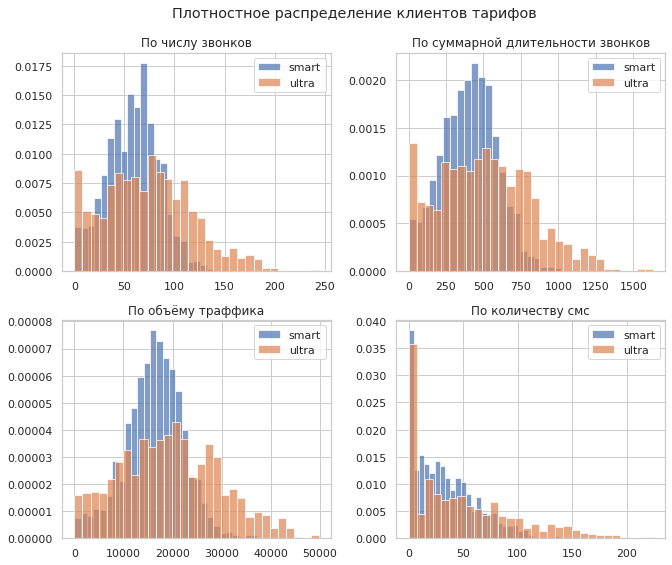

In [12]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,8))
axs=axs.flatten()

plt.suptitle('Плотностное распределение клиентов тарифов')

feature_list = {'calls': 'По числу звонков',
               'minutes': 'По суммарной длительности звонков',
               'mb_used': 'По объёму траффика',
               'messages': 'По количеству смс'}

for label, tarif in [(0,'smart'), (1, 'ultra')]:
    i = 0
    for key in feature_list.keys():    
        df.loc[df.loc[:, 'is_ultra']==label, key].hist(ax=axs[i], bins=30, label=tarif, density=True,
                                                       alpha=0.7)
        i += 1
    
i=0 
for key in feature_list.keys():
    axs[i].set_title(feature_list[key])
    axs[i].legend()
    i += 1

plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

На гистограммах хорошо видно "расползание" и смещение гистограммы в сторону больших значений у пользователей тарифа ultra. Вариабельность среди пользователей ultra выше. Интересна доля коротких звонков, которая заметно выше, чем у пользователей smart. 

### Тест на нормальность распределений

In [13]:
print('Проверка гипотез о нормальном характере распределения признаков')
print("""
H0 - распределения являются нормальными
H1 - распределения отличаются от нормальных
Уровень значимости alpha приму равным 5% alpha= 0.05
     """)
alpha = 0.05
for label, tarif in [(0,'smart'), (1, 'ultra')]:
    for ftr in df[df['is_ultra']==label].columns:
        p = stats.normaltest(df[df['is_ultra']==label][ftr]).pvalue
        print(f'\n{tarif}, {ftr}, pvalue={round(p, 4)}')
        if p < alpha:
            print('Отвергаю нулевую гипотезу о нормальности распределения, p < alpha')
        else:
            print('Нет оснований отвергать нулевую гипотезу, p >= alpha')

Проверка гипотез о нормальном характере распределения признаков

H0 - распределения являются нормальными
H1 - распределения отличаются от нормальных
Уровень значимости alpha приму равным 5% alpha= 0.05
     

smart, calls, pvalue=0.3905
Нет оснований отвергать нулевую гипотезу, p >= alpha

smart, minutes, pvalue=0.0145
Отвергаю нулевую гипотезу о нормальности распределения, p < alpha

smart, messages, pvalue=0.0
Отвергаю нулевую гипотезу о нормальности распределения, p < alpha

smart, mb_used, pvalue=0.0001
Отвергаю нулевую гипотезу о нормальности распределения, p < alpha

smart, is_ultra, pvalue=0.0
Отвергаю нулевую гипотезу о нормальности распределения, p < alpha

ultra, calls, pvalue=0.0
Отвергаю нулевую гипотезу о нормальности распределения, p < alpha

ultra, minutes, pvalue=0.0
Отвергаю нулевую гипотезу о нормальности распределения, p < alpha

ultra, messages, pvalue=0.0
Отвергаю нулевую гипотезу о нормальности распределения, p < alpha

ultra, mb_used, pvalue=0.0
Отвергаю нулевую 

С уровнем значимости alpha распределение клиентов по количеству звонков похоже на нормальное, pvalue > aplha в тесте. Остальные признаки распределены не нормально, почти у всех pvalue = 0.0 << alpha.

### Анализ взаимосвязи признаков. Корреляции и диаграммы рассеяния

Распределение признаков не соответствует нормальному закону, для анализа взаимосвязей использую непараметрический метод спирмена

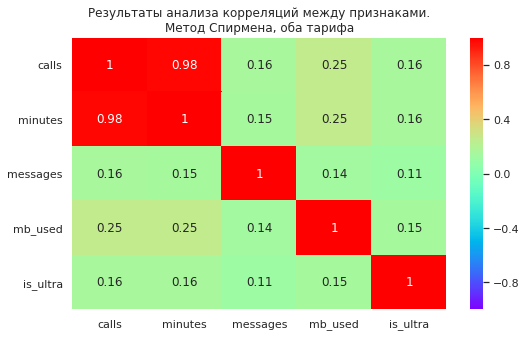

In [14]:
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(method='spearman').round(2), center=0, vmin=-1, vmax=1, annot=True, cmap='rainbow')
plt.title('Результаты анализа корреляций между признаками.\nМетод Спирмена, оба тарифа')
plt.tight_layout(rect=(0, 0, 0.97, 0.97))
plt.show()

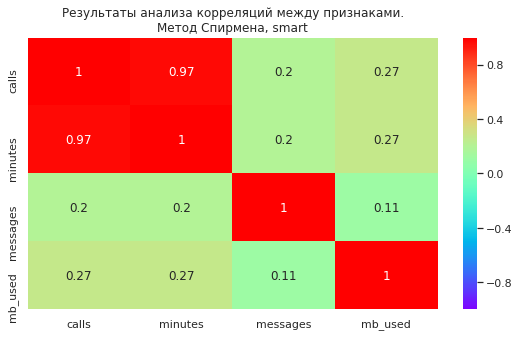

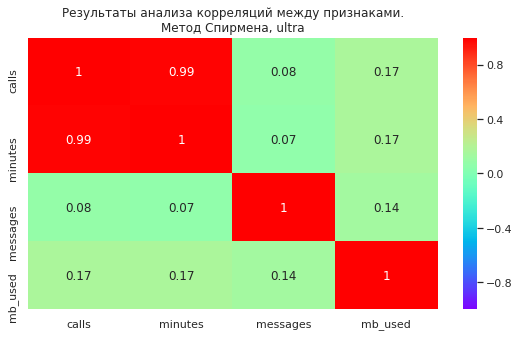

In [15]:
for label, tarif in [(0,'smart'), (1, 'ultra')]:
    plt.figure(figsize=(8,5))
    sns.heatmap(df[df['is_ultra']==label].drop(columns='is_ultra').corr(method='spearman').round(2), 
                center=0, vmin=-1, vmax=1, annot=True, cmap='rainbow')
    plt.title(f'Результаты анализа корреляций между признаками.\nМетод Спирмена, {tarif}')
    plt.tight_layout(rect=(0, 0, 0.97, 0.97))
    plt.show()

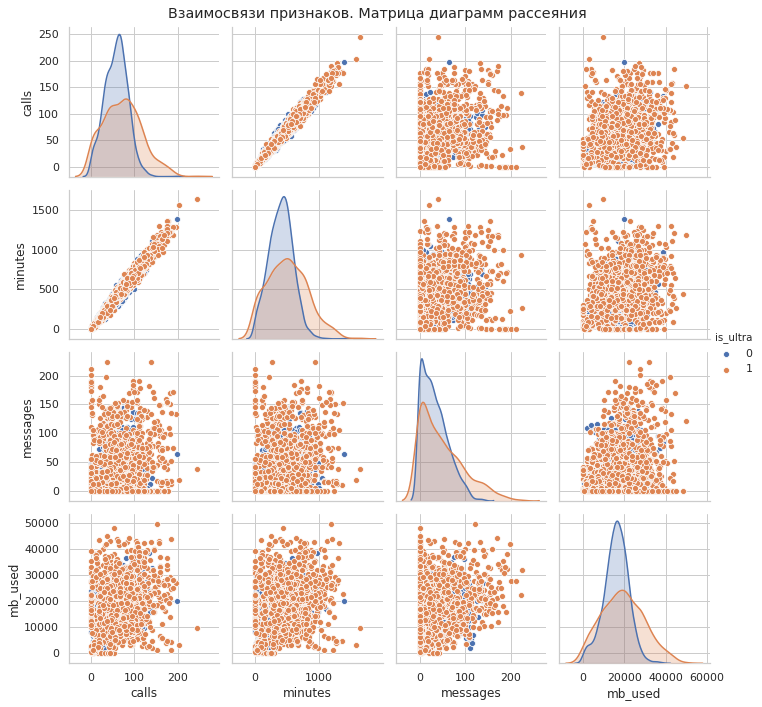

In [16]:
sns.pairplot(df, hue="is_ultra", vars=df.drop(columns='is_ultra').columns)
plt.suptitle('Взаимосвязи признаков. Матрица диаграмм рассеяния')
plt.tight_layout(rect=(0, 0, 0.97, 0.97))
plt.show()

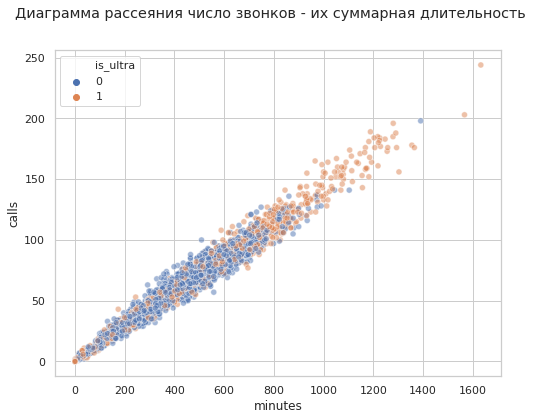

In [17]:
plt.figure(figsize=(8,6))
plt.suptitle('Диаграмма рассеяния число звонков - их суммарная длительность')
sns.scatterplot(x='minutes', y='calls', hue="is_ultra", data=df, alpha=0.5)
plt.show()

<h2 style="color:DodgerBlue"> Результаты анализа взаимосвязей и гистограмм </h2>

Признаки, за исключением количества звонков в тарифе smart, распределены не по нормальному закону.


В обоих тарифах суммарная длительность звонков сильно линейно (коэффициент корреляции 0.97 - 0.99, метод Спирмена) связана с их количеством. Логичная взаимосвязь. Других взаимосвязей не выявлено


Покольку два признака сильно связаны, можно один из них попробовать исключить при построении моделей. Сперва проведу анализ моделей по 4 признакам, затем исключу признак minutes и сравню результат.

<h2 style="color:DodgerBlue">1.3 Подготовка данных для моделей</h2>

Разделю выборки на обучающую (60%), валидационную (20%) и тестовую (20%):

In [18]:
tr_val_df, test_df = train_test_split(df, test_size=0.20, random_state=RND)

In [19]:
train_df, valid_df = train_test_split(tr_val_df, test_size=0.25, random_state=RND)

In [20]:
print(f'Размер обучающей выборки: {train_df.shape}, {len(train_df)/len(df):.2%}')
print(f'Размер валидационной выборки: {valid_df.shape}, {len(valid_df)/len(df):.2%}')
print(f'Размер тестовой выборки: {test_df.shape}, {len(test_df)/len(df):.2%}')

Размер обучающей выборки: (1928, 5), 59.99%
Размер валидационной выборки: (643, 5), 20.01%
Размер тестовой выборки: (643, 5), 20.01%


<h1 style="color:SteelBlue; font-size:200%">2. Обучение, подбор гиперпараметров и исследование качества моделей</h1>

Подберу для моделей оптимальные гиперпараметры, обучая на обучающей выборке и тестируя на валидационной. 
Буду ориентироваться на средневзвешенную f-метрику (accuracy возьму как дополнительный параметр)

Затем для этих параметров обучу модели на выборке обучающая+валидационная и проверю на тестовой. Выберу лучшую модель

Начну с решающего дерева, на нём подберу оптимальную максимальную глубину max_depth. 

Потом, используя эту глубину, подберу для случайного леса оптимальное количество деревьев n_estimators.

In [21]:
#функция отделения целевого признака от предикторов
def feature_target(df):
    df_feature = df.drop(columns='is_ultra')
    df_target = df.loc[:, 'is_ultra']
    return (df_feature, df_target)

In [22]:
#функция обучения и расчёта метрик качества модели

def fit_validation(train_df, valid_df, model='tree', **kwargs):
    
    #словарь именованных аргументов:
    kwargs_dict = {'n_estimators' : 100,
                   'max_depth' : None
                  }
    try:
        for key in kwargs_dict:
            for arg in kwargs:
                if key == arg:
                    kwargs_dict[key] = kwargs[arg] 
    except:
        print('kwargs ERROR')
    
    train_feature, train_target = feature_target(train_df)
    valid_feature, valid_target = feature_target(valid_df)    
        
    if model == 'tree':
        model = DecisionTreeClassifier(random_state=RND, max_depth=kwargs_dict['max_depth'])
    elif model == 'forest':
        model = RandomForestClassifier(random_state=RND, 
                                      n_estimators=kwargs_dict['n_estimators'], 
                                      max_depth=kwargs_dict['max_depth'])
    elif model == 'regression':
        model = LogisticRegression(random_state=RND)
    else:
        return 'ERROR. Incorrect model name. Use "tree", "forest", "regression".'
    
    model.fit(train_feature, train_target)
    train_predict = model.predict(train_feature)
    valid_predict = model.predict(valid_feature)
    
    train_report = classification_report(train_target, train_predict, output_dict=True)
    valid_report = classification_report(valid_target, valid_predict, output_dict=True)
    
    fit_validation = namedtuple('fit_validation', ('model', 'train_report', 'valid_report'))
    return fit_validation(model, train_report, valid_report)

In [23]:
def valid_graph(arr, title):
    #plt.figure(figsize=(8,4))
    sns.lineplot(y = arr, x = [i+1 for i in range(0,len(arr))])
    plt.xlabel('parameter')
    plt.ylabel('metric value')
    plt.title('parameter - metric')
    if len(arr) >= 30:
        plt.xticks(range(0, len(arr), 5))
    else:
        plt.xticks(range(len(arr)))
    plt.title(title)
    #plt.show()

<h2 style="color:DodgerBlue">2.1 Решающее дерево</h2>

In [24]:
train_acc_arr = []
valid_acc_arr = []
train_weighted_avg_f = []
valid_weighted_avg_f = []
model_arr = []

for depth in range (1,21):
    fv = fit_validation(train_df, valid_df, model='tree', max_depth=depth)
    train_acc_arr.append(fv.train_report['accuracy'])
    valid_acc_arr.append(fv.valid_report['accuracy'])
    train_weighted_avg_f.append(fv.train_report['weighted avg']['f1-score'])
    valid_weighted_avg_f.append(fv.valid_report['weighted avg']['f1-score'])
    model_arr.append(fv.model)

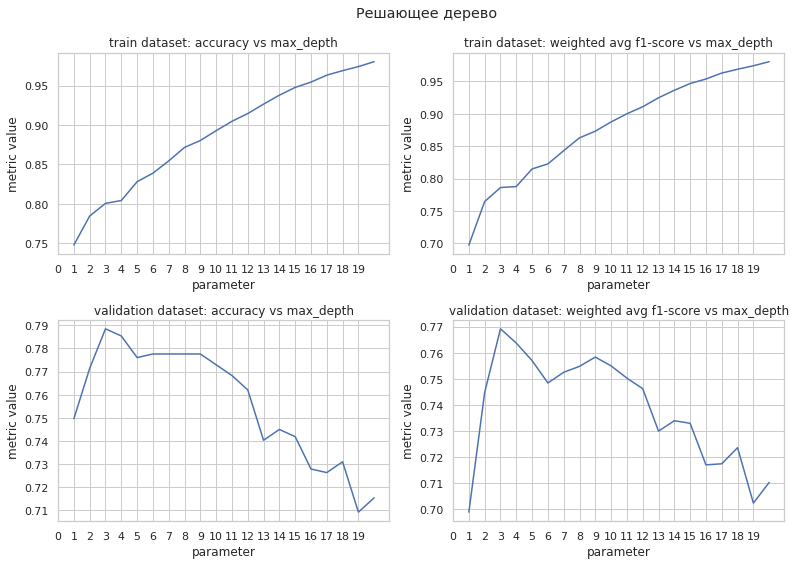

In [25]:
plt.figure(figsize=(12,8))
plt.subplot(221)
valid_graph(train_acc_arr, 'train dataset: accuracy vs max_depth')
plt.subplot(223)
valid_graph(valid_acc_arr, 'validation dataset: accuracy vs max_depth')
plt.subplot(222)
valid_graph(train_weighted_avg_f, 'train dataset: weighted avg f1-score vs max_depth')
plt.subplot(224)
valid_graph(valid_weighted_avg_f, 'validation dataset: weighted avg f1-score vs max_depth')
plt.suptitle('Решающее дерево')
plt.tight_layout(rect=(0,0,0.95,0.95))
plt.show()

Лучшая глубина решающего дерева - <code>max_depth 3 или 4</code>. Слева от 3 большой риск недообучения, возьму <code>max_depth=4</code>

Обучу модель на выборке train + validation <code>tr_val_df</code> и протестирую на тестовом датасете

In [26]:
best_depth = 4
fv = fit_validation(tr_val_df, test_df, model='tree', max_depth=best_depth)
tree_model = fv.model
tree_model_acc = fv.valid_report["accuracy"]
tree_model_f1_score = fv.valid_report["weighted avg"]["f1-score"]
print('model:', tree_model)
print(f'Test dataset accuracy with max_depth {best_depth}: {tree_model_acc:.2f}')
print(f'Test dataset weighted average f1-score with max_depth {best_depth}: {tree_model_f1_score:.2f}')

model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=271828, splitter='best')
Test dataset accuracy with max_depth 4: 0.79
Test dataset weighted average f1-score with max_depth 4: 0.77


<h2 style="color:DodgerBlue">2.2 Случайный лес</h2>

Для оценки оптимельного количества деревьев приму <code>max_depth = 4 на основании анализа решающего дерева</code>

In [27]:
train_acc_arr = []
valid_acc_arr = []
train_weighted_avg_f = []
valid_weighted_avg_f = []
model_arr = []
max_depth = 4

for n_estimators in range (1,101):
    fv = fit_validation(train_df, valid_df, model='forest', max_depth=max_depth, n_estimators=n_estimators)
    train_acc_arr.append(fv.train_report['accuracy'])
    valid_acc_arr.append(fv.valid_report['accuracy'])
    train_weighted_avg_f.append(fv.train_report['weighted avg']['f1-score'])
    valid_weighted_avg_f.append(fv.valid_report['weighted avg']['f1-score'])
    model_arr.append(fv.model)

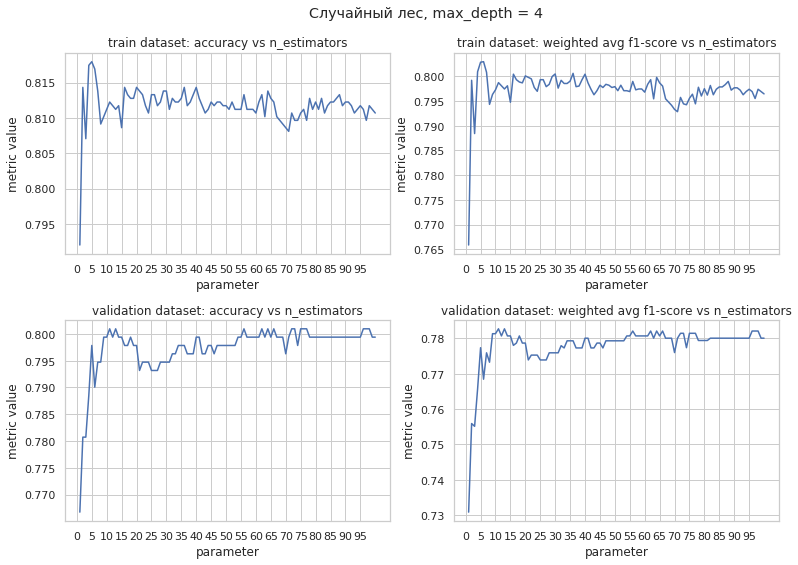

In [28]:
plt.figure(figsize=(12,8))
plt.subplot(221)
valid_graph(train_acc_arr, 'train dataset: accuracy vs n_estimators')
plt.subplot(223)
valid_graph(valid_acc_arr, 'validation dataset: accuracy vs n_estimators')
plt.subplot(222)
valid_graph(train_weighted_avg_f, 'train dataset: weighted avg f1-score vs n_estimators')
plt.subplot(224)
valid_graph(valid_weighted_avg_f, 'validation dataset: weighted avg f1-score vs n_estimators')
plt.suptitle(f'Случайный лес, max_depth = {max_depth}')
plt.tight_layout(rect=(0,0,0.95,0.95))
plt.show()

Самые лучшие результаты по валидационному датасету в районе 10-15 деревьев. Возьму 13, счастливое число.

На всякий случай проверю, что при большей глубине не лучше:

In [29]:
train_acc_arr = []
valid_acc_arr = []
train_weighted_avg_f = []
valid_weighted_avg_f = []
model_arr = []
max_depth = 8

for n_estimators in range (1,101):
    fv = fit_validation(train_df, valid_df, model='forest', max_depth=max_depth, n_estimators=n_estimators)
    train_acc_arr.append(fv.train_report['accuracy'])
    valid_acc_arr.append(fv.valid_report['accuracy'])
    train_weighted_avg_f.append(fv.train_report['weighted avg']['f1-score'])
    valid_weighted_avg_f.append(fv.valid_report['weighted avg']['f1-score'])
    model_arr.append(fv.model)

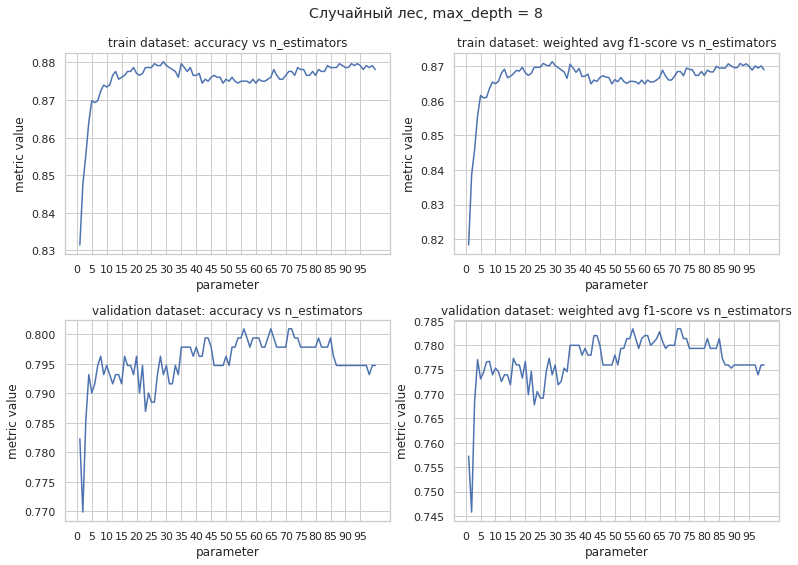

In [30]:
plt.figure(figsize=(12,8))
plt.subplot(221)
valid_graph(train_acc_arr, 'train dataset: accuracy vs n_estimators')
plt.subplot(223)
valid_graph(valid_acc_arr, 'validation dataset: accuracy vs n_estimators')
plt.subplot(222)
valid_graph(train_weighted_avg_f, 'train dataset: weighted avg f1-score vs n_estimators')
plt.subplot(224)
valid_graph(valid_weighted_avg_f, 'validation dataset: weighted avg f1-score vs n_estimators')
plt.suptitle(f'Случайный лес, max_depth = {max_depth}')
plt.tight_layout(rect=(0,0,0.95,0.95))
plt.show()

Не лучше. Приму max_depth = 4 и n_estimators = 13.

Обучу модель на выборке train + validation <code>tr_val_df</code> и протестирую на тестовом датасете

In [31]:
best_depth = 4
best_est = 13
fv = fit_validation(tr_val_df, test_df, model='forest', 
                    max_depth=best_depth, n_estimators=best_est)
forest_model = fv.model
forest_model_acc = fv.valid_report["accuracy"]
forest_model_f1_score = fv.valid_report["weighted avg"]["f1-score"]
print('model:', forest_model)
print(f'Test dataset accuracy with max_depth {best_depth}, n_estimtors {best_est}: {forest_model_acc:.2f}')
print(f'Test dataset weighted average f1-score with max_depth {best_depth}, n_estimtors {best_est}: {forest_model_f1_score:.2f}')

model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=13,
                       n_jobs=None, oob_score=False, random_state=271828,
                       verbose=0, warm_start=False)
Test dataset accuracy with max_depth 4, n_estimtors 13: 0.81
Test dataset weighted average f1-score with max_depth 4, n_estimtors 13: 0.79


In [32]:
forest_model = fit_validation(tr_val_df, valid_df, model='forest', max_depth=4, n_estimators=13).model

<h2 style="color:DodgerBlue">2.3 Логистическая регрессия</h2>

In [33]:
fv = fit_validation(tr_val_df, test_df, model='regression')
regression_model = fv.model
regression_model_acc = fv.valid_report["accuracy"]
regression_model_f1_score = fv.valid_report["weighted avg"]["f1-score"]
print('model:', regression_model)
print(f'Test dataset accuracy: {regression_model_acc:.2f}')
print(f'Test dataset weighted average f1-score: {regression_model_f1_score:.2f}')

model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=271828, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Test dataset accuracy: 0.72
Test dataset weighted average f1-score: 0.62


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<h1 style="color:SteelBlue; font-size:200%">Результаты настройки моделей</h1>

**Обучены три модели, гиперпараметры оптимизированы на валидационной выборке. После оптимизации модели с выбранными гиперпараметрами обучены на объединённой обучающе-валидационной выборке и протестированы на тестовой выборке.**

- Решающее дерево с максимальной глубиной 4:

In [34]:
print('model:', tree_model)
print(f'\nTest dataset accuracy with max_depth {best_depth}: {tree_model_acc:.2f}')
print(f'Test dataset weighted average f1-score with max_depth {best_depth}: {tree_model_f1_score:.2f}')

model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=271828, splitter='best')

Test dataset accuracy with max_depth 4: 0.79
Test dataset weighted average f1-score with max_depth 4: 0.77


- Случайный лес с максимальной глубиной деревьев 4 и количеством 13:

In [35]:
print('model:', forest_model)
print(f'\nTest dataset accuracy with max_depth {best_depth}, n_estimtors {best_est}: {forest_model_acc:.2f}')
print(f'Test dataset weighted average f1-score with max_depth {best_depth}, n_estimtors {best_est}: {forest_model_f1_score:.2f}')

model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=13,
                       n_jobs=None, oob_score=False, random_state=271828,
                       verbose=0, warm_start=False)

Test dataset accuracy with max_depth 4, n_estimtors 13: 0.81
Test dataset weighted average f1-score with max_depth 4, n_estimtors 13: 0.79


- Логистическая регрессия

In [36]:
print('model:', regression_model)
print(f'\nTest dataset accuracy: {regression_model_acc:.2f}')
print(f'Test dataset weighted average f1-score: {regression_model_f1_score:.2f}')

model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=271828, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Test dataset accuracy: 0.72
Test dataset weighted average f1-score: 0.62


<h1 style="color:SteelBlue; font-size:200%">3. Проверка скорости, адекватности, сравнение моделей</h1>

<h2 style="color:DodgerBlue">3.1 Проверка адекватности моделей</h2>

Для проверки адекватности моделей сравню результаты их работы с моделью, которая всегда предсказывает константу. В качестве константы возьму метку самого объёмного класса: 0. Также сравню со случайной моделью. 

In [37]:
feature, target = feature_target(tr_val_df)

In [38]:
const_predict = [0 for i in range (0, len(target))]
const_accuracy = classification_report(target, const_predict, output_dict=True)['accuracy']
const_f1_score = classification_report(target, const_predict, output_dict=True)['weighted avg']['f1-score']
print('метрики качества для константной модели')
print(f"accuracy {const_accuracy:.2f}")
print(f"weighted avg f1-score {const_f1_score:.2f}")

метрики качества для константной модели
accuracy 0.69
weighted avg f1-score 0.56


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
random_predict = [random.choice([0, 1]) for i in range (0, len(target))]
random_accuracy = classification_report(target, random_predict, output_dict=True)['accuracy']
random_f1_score = classification_report(target, random_predict, output_dict=True)['weighted avg']['f1-score']
print('метрики качества для случайной модели')
print(f"accuracy {random_accuracy:.2f}")
print(f"weighted avg f1-score {random_f1_score:.2f}")

метрики качества для случайной модели
accuracy 0.49
weighted avg f1-score 0.51


У всех обученных моделей метрики качества выше (особенно F-мера), модели адекватны. Достаточно высокое значение accuracy в константной модели объясняется преобладанием класса 0 в данных. В условиях неравных классов accuracy работает плохо.

<h2 style="color:DodgerBlue">3.2 Проверка скорости работы моделей</h2>

Чтобы проверить скорость работы моделей, нужен датасет побольше. Искусственно раздую датасет до 100000, склеив несколько имеющихся датасетов.

In [40]:
frames = [df.iloc[:1000, :] for i in range (0,100)]
df_time_test = pd.concat(frames)

In [41]:
df_time_test.shape

(100000, 5)

Теперь применю модели для предсказания целевой переменной по этому датасету, каждую модель - 100 раз. Посчитаю среднее время предсказания.

In [42]:
mean_time_arr = []
mean_err_arr = []

for model, model_name in [(tree_model, 'tree'), 
                          (forest_model, 'forest'),
                          (regression_model, 'regression')]:
    sum_time = []
    for i in range (0, 100):
        start = datetime.now()
        model.predict(df_time_test.drop(columns='is_ultra'))
        end = datetime.now()
        sum_time.append((end - start).microseconds)           
    
    mean_time = int(np.mean(sum_time))
    mean_err = int(2*np.std(sum_time)/(100**0.5))
    
    mean_time_arr.append(mean_time)
    mean_err_arr.append(mean_err)
    
    print(f'{model_name}\nзатрачено времени: {mean_time:.0f} +/- {mean_err:.0f} мкс')

tree
затрачено времени: 6245 +/- 249 мкс
forest
затрачено времени: 65921 +/- 1961 мкс
regression
затрачено времени: 48616 +/- 8591 мкс


<h2 style="color:DodgerBlue">3.2 Сравнительная таблица моделей</h2>

In [43]:
min_time = min(mean_time_arr)
time_ratio = []
for time in mean_time_arr:
    time_ratio.append(round((time/min_time), 2))

In [44]:
data =  [
        ['tree', tree_model_acc, tree_model_f1_score, time_ratio[0], f'{mean_time_arr[0]} +/- {mean_err_arr[0]}'],
        ['forest', forest_model_acc, forest_model_f1_score, time_ratio[1], f'{mean_time_arr[1]} +/- {mean_err_arr[1]}'],
        ['regression', regression_model_acc, regression_model_f1_score, time_ratio[2], f'{mean_time_arr[2]} +/- {mean_err_arr[2]}']
        ]
columns = ['ML model', 'accuracy', 'weighted avg f1-score', 'speed ratio', f'average time to predict {df_time_test.shape[0]} targets, mcs']
description_df = pd.DataFrame(data=data, columns=columns)
description_df.iloc[:, 1] = description_df.iloc[:, 1].round(2)
description_df.iloc[:, 2] = description_df.iloc[:, 2].round(2)
description_df

,ML model,accuracy,weighted avg f1-score,speed ratio,"average time to predict 100000 targets, mcs"
0,tree,0.79,0.77,1.00,6245 +/- 249
1,forest,0.81,0.79,10.56,65921 +/- 1961
2,regression,0.72,0.62,7.78,48616 +/- 8591


<h1 style="color:SteelBlue; font-size:200%">Результаты проверки адекватности и сравнения моделей</h1>

Адекватность проверена в сравнении со случайной и константной моделями, в обоих случаях у обученных моделей accuracy и weighted avg f1-score выше, модели адекватны.

Среди обученных моделей все справились с предсказанием по датасету в 100 тыс. объектов менее чем за 0,1 секунды. 

- **случайный лес (forest)**: медленнее всех работает <code>68533 +/- 1086 мкс на 100 тыс. объектов</code>, но он самый точный: <code>accuracy 0.81, weighted avg f1-score 0.79</code> Лучше всего использовать эту модель.

- если критична скорость работы, можно рекомендовать **решающее дерево (tree)** с <code>7885 +/- 1500 мкс на 100 тыс. объектов, accuracy 0.79, weighted avg f1-score 0.77</code>.

- **логистическая регрессия (regression)** в данном случае самая неточная, хотя и самая быстрая <code>4960 +/- 977 мкс на 100 тыс. объектов, accuracy 0.75, weighted avg f1-score 0.70</code>.

<h1 style="color:SteelBlue; font-size:200%">Результаты разработки модели для подбора тарифа сотовой связи</h1>

**Обучены три модели, их качество проверено на тестовой выборке:**

- случайный лес <code>'forest_model'</code> с максимальной глубиной деревьев 4 и количеством 13

In [45]:
print(f'\nTest dataset accuracy with max_depth {best_depth}, n_estimtors {best_est}: {forest_model_acc:.2f}')
print(f'Test dataset weighted average f1-score with max_depth {best_depth}, n_estimtors {best_est}: {forest_model_f1_score:.2f}')


Test dataset accuracy with max_depth 4, n_estimtors 13: 0.81
Test dataset weighted average f1-score with max_depth 4, n_estimtors 13: 0.79


- решающее дерево <code>'tree_model'</code> с максимальной глубиной 4

In [46]:
print(f'\nTest dataset accuracy with max_depth {best_depth}: {tree_model_acc:.2f}')
print(f'Test dataset weighted average f1-score with max_depth {best_depth}: {tree_model_f1_score:.2f}')


Test dataset accuracy with max_depth 4: 0.79
Test dataset weighted average f1-score with max_depth 4: 0.77


- логистическая регрессия <code>'regression_model'</code>

In [47]:
print(f'\nTest dataset accuracy: {regression_model_acc:.2f}')
print(f'Test dataset weighted average f1-score: {regression_model_f1_score:.2f}')


Test dataset accuracy: 0.72
Test dataset weighted average f1-score: 0.62


Модели проверены на адекватность сравнением с константной и случайной моделью. У всех обученных моделей метрики качества выше (особенно F-мера), модели адекватны.

Среди обученных моделей все справились с предсказанием по датасету в 100 тыс. объектов менее чем за 0,1 секунды.
 
- **случайный лес (forest)**: медленнее всех работает <code>68533 +/- 1086 мкс на 100 тыс. объектов</code>, но он самый точный: <code>accuracy 0.81, weighted avg f1-score 0.79</code> Лучше всего использовать эту модель.

- если критична скорость работы, можно рекомендовать **решающее дерево (tree)** с <code>7885 +/- 1500 мкс на 100 тыс. объектов, accuracy 0.79, weighted avg f1-score 0.77</code>.

- **логистическая регрессия (regression)** в данном случае самая неточная, хотя и самая быстрая <code>4960 +/- 977 мкс на 100 тыс. объектов, accuracy 0.75, weighted avg f1-score 0.70</code>.

In [48]:
description_df.sort_values(by='weighted avg f1-score', ascending=False)

,ML model,accuracy,weighted avg f1-score,speed ratio,"average time to predict 100000 targets, mcs"
1,forest,0.81,0.79,10.56,65921 +/- 1961
0,tree,0.79,0.77,1.00,6245 +/- 249
2,regression,0.72,0.62,7.78,48616 +/- 8591


<div style="border:solid SteelBlue  2px; padding: 20px"> 
<h1 style="color:SteelBlue; font-size:200%">Дополнительный блок: построение моделей на данных без признака minutes</h1>

В корреляционном анализе выяснилось, что для обоих тарифов суммарная длительность звонков сильно линейно (коэффициент корреляции 0.97 - 0.99, метод Спирмена) связана с их количеством. Логичная взаимосвязь. Других взаимосвязей не выявлено

Покольку два признака сильно связаны, можно один из них попробовать исключить при построении моделей. Сделаю такой анализ и сравню с уже выполненным по 4 признакам. Исключу продолжительность звонков. В том числе потому, что данный оператор округляет продолжительность вверх. Возможно, количество звонков для модели будет актуальнее, чем их продолжительность.

In [49]:
#переопределю функцию, дропнув из признаков минуты
def feature_target(df):
    df_feature = df.drop(columns=['is_ultra', 'minutes'])
    df_target = df.loc[:, 'is_ultra']
    return (df_feature, df_target)

#и эту на всякий случай, чтоб не было ошибок в случае "подсоса" в ней старой функции feature_target
def fit_validation(train_df, valid_df, model='tree', **kwargs):
    
    #словарь именованных аргументов:
    kwargs_dict = {'n_estimators' : 100,
                   'max_depth' : None
                  }
    try:
        for key in kwargs_dict:
            for arg in kwargs:
                if key == arg:
                    kwargs_dict[key] = kwargs[arg] 
    except:
        print('kwargs ERROR')
    
    train_feature, train_target = feature_target(train_df)
    valid_feature, valid_target = feature_target(valid_df)    
        
    if model == 'tree':
        model = DecisionTreeClassifier(random_state=RND, max_depth=kwargs_dict['max_depth'])
    elif model == 'forest':
        model = RandomForestClassifier(random_state=RND, 
                                      n_estimators=kwargs_dict['n_estimators'], 
                                      max_depth=kwargs_dict['max_depth'])
    elif model == 'regression':
        model = LogisticRegression(random_state=RND)
    else:
        return 'ERROR. Incorrect model name. Use "tree", "forest", "regression".'
    
    model.fit(train_feature, train_target)
    train_predict = model.predict(train_feature)
    valid_predict = model.predict(valid_feature)
    
    train_report = classification_report(train_target, train_predict, output_dict=True)
    valid_report = classification_report(valid_target, valid_predict, output_dict=True)
    
    fit_validation = namedtuple('fit_validation', ('model', 'train_report', 'valid_report'))
    return fit_validation(model, train_report, valid_report)

## Решающее дерево, без признака minutes

In [50]:
train_acc_arr = []
valid_acc_arr = []
train_weighted_avg_f = []
valid_weighted_avg_f = []
model_arr = []

for depth in range (1,21):
    fv = fit_validation(train_df, valid_df, model='tree', max_depth=depth)
    train_acc_arr.append(fv.train_report['accuracy'])
    valid_acc_arr.append(fv.valid_report['accuracy'])
    train_weighted_avg_f.append(fv.train_report['weighted avg']['f1-score'])
    valid_weighted_avg_f.append(fv.valid_report['weighted avg']['f1-score'])
    model_arr.append(fv.model)

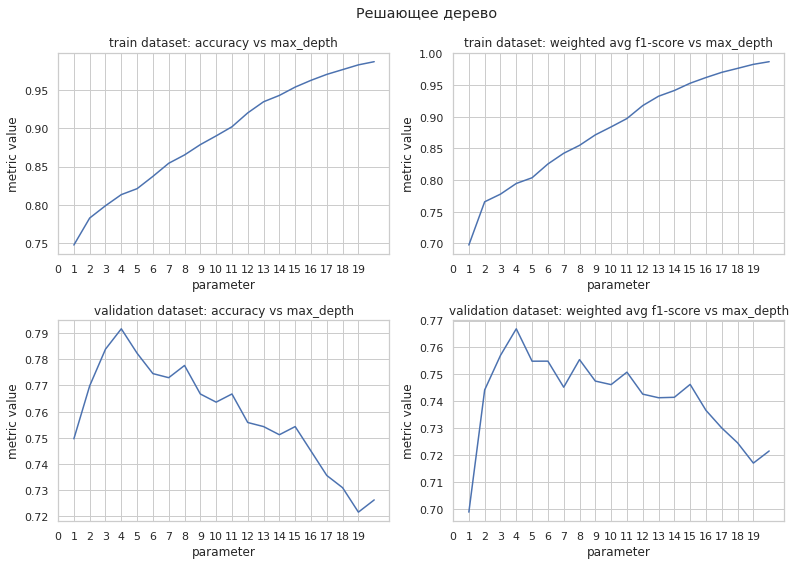

In [51]:
plt.figure(figsize=(12,8))
plt.subplot(221)
valid_graph(train_acc_arr, 'train dataset: accuracy vs max_depth')
plt.subplot(223)
valid_graph(valid_acc_arr, 'validation dataset: accuracy vs max_depth')
plt.subplot(222)
valid_graph(train_weighted_avg_f, 'train dataset: weighted avg f1-score vs max_depth')
plt.subplot(224)
valid_graph(valid_weighted_avg_f, 'validation dataset: weighted avg f1-score vs max_depth')
plt.suptitle('Решающее дерево')
plt.tight_layout(rect=(0,0,0.95,0.95))
plt.show()

Лучшая глубина решающего дерева - <code>max_depth 3 - 5</code>. Получается, всё же, аналогично 4 признакам, оптимальный вариант <code>max_depth=4</code>. Но дерево стало стабильнее, меньше переобучения.

Обучу модель на выборке train + validation <code>tr_val_df</code> и протестирую на тестовом датасете

In [52]:
best_depth_new = 4
fv = fit_validation(tr_val_df, test_df, model='tree', max_depth=best_depth_new)
tree_model_new = fv.model
tree_model_f1_score_new = fv.valid_report["accuracy"]
tree_model_acc_new = fv.valid_report["weighted avg"]["f1-score"]
print('model:', tree_model_new)
print(f'Test dataset accuracy with max_depth {best_depth}: {tree_model_acc_new:.2f}')
print(f'Test dataset weighted average f1-score with max_depth {best_depth}: {tree_model_f1_score_new:.2f}')

model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=271828, splitter='best')
Test dataset accuracy with max_depth 4: 0.77
Test dataset weighted average f1-score with max_depth 4: 0.79


## Случайный лес, без признака minutes

Для оценки оптимельного количества деревьев приму <code>max_depth = 4 на основании анализа решающего дерева</code>

In [53]:
train_acc_arr = []
valid_acc_arr = []
train_weighted_avg_f = []
valid_weighted_avg_f = []
model_arr = []

for n_estimators in range (1,101):
    fv = fit_validation(train_df, valid_df, model='forest', max_depth=best_depth_new, n_estimators=n_estimators)
    train_acc_arr.append(fv.train_report['accuracy'])
    valid_acc_arr.append(fv.valid_report['accuracy'])
    train_weighted_avg_f.append(fv.train_report['weighted avg']['f1-score'])
    valid_weighted_avg_f.append(fv.valid_report['weighted avg']['f1-score'])
    model_arr.append(fv.model)

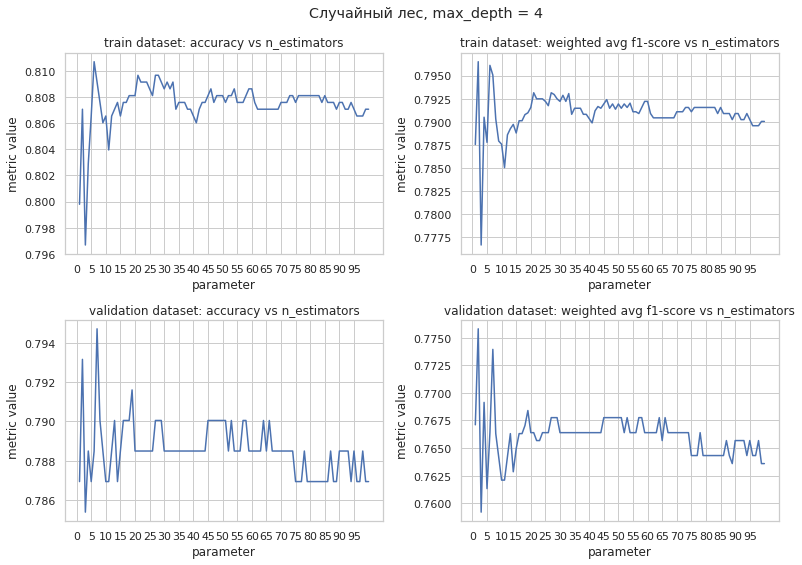

In [54]:
plt.figure(figsize=(12,8))
plt.subplot(221)
valid_graph(train_acc_arr, 'train dataset: accuracy vs n_estimators')
plt.subplot(223)
valid_graph(valid_acc_arr, 'validation dataset: accuracy vs n_estimators')
plt.subplot(222)
valid_graph(train_weighted_avg_f, 'train dataset: weighted avg f1-score vs n_estimators')
plt.subplot(224)
valid_graph(valid_weighted_avg_f, 'validation dataset: weighted avg f1-score vs n_estimators')
plt.suptitle(f'Случайный лес, max_depth = {best_depth_new}')
plt.tight_layout(rect=(0,0,0.95,0.95))
plt.show()

Результаты f-меры болтаются в районе 0.77. Стабильность наступает с 20 деревьев.
Проверю глубину 8:

In [55]:
train_acc_arr = []
valid_acc_arr = []
train_weighted_avg_f = []
valid_weighted_avg_f = []
model_arr = []

for n_estimators in range (1,101):
    fv = fit_validation(train_df, valid_df, model='forest', max_depth=8, n_estimators=n_estimators)
    train_acc_arr.append(fv.train_report['accuracy'])
    valid_acc_arr.append(fv.valid_report['accuracy'])
    train_weighted_avg_f.append(fv.train_report['weighted avg']['f1-score'])
    valid_weighted_avg_f.append(fv.valid_report['weighted avg']['f1-score'])
    model_arr.append(fv.model)

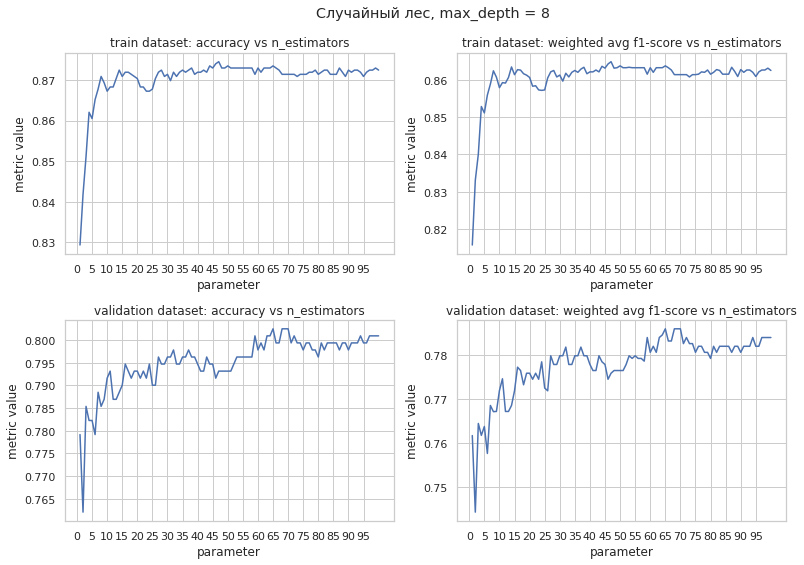

In [56]:
plt.figure(figsize=(12,8))
plt.subplot(221)
valid_graph(train_acc_arr, 'train dataset: accuracy vs n_estimators')
plt.subplot(223)
valid_graph(valid_acc_arr, 'validation dataset: accuracy vs n_estimators')
plt.subplot(222)
valid_graph(train_weighted_avg_f, 'train dataset: weighted avg f1-score vs n_estimators')
plt.subplot(224)
valid_graph(valid_weighted_avg_f, 'validation dataset: weighted avg f1-score vs n_estimators')
plt.suptitle(f'Случайный лес, max_depth = 8')
plt.tight_layout(rect=(0,0,0.95,0.95))
plt.show()

Картина другая, при 65-70 деревьев результат чуть лучше ранее полученного при 20 и глубине 4. Но модель будет в разы объёмнее при сомнительном приросте в качестве (0.01-0.02, и это если не будет переобучения из-за глубины, параметров то всего 3). И при глубине 4 больше стабильности. Приму max_depth = 4 и n_estimators = 20.

Обучу модель на выборке train + validation <code>tr_val_df</code> и протестирую на тестовом датасете

In [57]:
best_est_new = 20
fv = fit_validation(tr_val_df, test_df, model='forest', 
                    max_depth=best_depth, n_estimators=best_est)
forest_model_new = fv.model
forest_model_acc_new = fv.valid_report["accuracy"]
forest_model_f1_score_new = fv.valid_report["weighted avg"]["f1-score"]
print('model:', forest_model_new)
print(f'Test dataset accuracy with max_depth {best_depth_new}, n_estimtors {best_est_new}: {forest_model_acc_new:.2f}')
print(f'Test dataset weighted average f1-score with max_depth {best_depth_new}, n_estimtors {best_est_new}: {forest_model_f1_score_new:.2f}')

model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=13,
                       n_jobs=None, oob_score=False, random_state=271828,
                       verbose=0, warm_start=False)
Test dataset accuracy with max_depth 4, n_estimtors 20: 0.79
Test dataset weighted average f1-score with max_depth 4, n_estimtors 20: 0.76


## Логистическая регрессия, без признака minutes

In [58]:
fv = fit_validation(tr_val_df, test_df, model='regression')
regression_model_new = fv.model
regression_model_acc_new = fv.valid_report["accuracy"]
regression_model_f1_score_new = fv.valid_report["weighted avg"]["f1-score"]
print('model:', regression_model_new)
print(f'Test dataset accuracy: {regression_model_acc_new:.2f}')
print(f'Test dataset weighted average f1-score: {regression_model_f1_score_new:.2f}')

model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=271828, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Test dataset accuracy: 0.75
Test dataset weighted average f1-score: 0.68


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Результаты настройки моделей без minutes

- Решающее дерево с максимальной глубиной 4:

In [59]:
print('model:', tree_model_new)
print(f'\nTest dataset accuracy with max_depth {best_depth_new}: {tree_model_acc_new:.2f}')
print(f'Test dataset weighted average f1-score with max_depth {best_depth_new}: {tree_model_f1_score_new:.2f}')

model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=271828, splitter='best')

Test dataset accuracy with max_depth 4: 0.77
Test dataset weighted average f1-score with max_depth 4: 0.79


- Случайный лес с максимальной глубиной деревьев 4 и количеством 13:

In [60]:
print('model:', forest_model_new)
print(f'\nTest dataset accuracy with max_depth {best_depth_new}, n_estimtors {best_est_new}: {forest_model_acc_new:.2f}')
print(f'Test dataset weighted average f1-score with max_depth {best_depth_new}, n_estimtors {best_est_new}: {forest_model_f1_score_new:.2f}')

model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=13,
                       n_jobs=None, oob_score=False, random_state=271828,
                       verbose=0, warm_start=False)

Test dataset accuracy with max_depth 4, n_estimtors 20: 0.79
Test dataset weighted average f1-score with max_depth 4, n_estimtors 20: 0.76


- Логистическая регрессия

In [61]:
print('model:', regression_model_new)
print(f'\nTest dataset accuracy: {regression_model_acc_new:.2f}')
print(f'Test dataset weighted average f1-score: {regression_model_f1_score_new:.2f}')

model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=271828, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Test dataset accuracy: 0.75
Test dataset weighted average f1-score: 0.68


In [69]:
mean_time_arr_new = []
mean_err_arr_new = []

for model, model_name in [(tree_model_new, 'tree_new'), 
                          (forest_model_new, 'forest_new'),
                          (regression_model_new, 'regression_new')]:
    sum_time = []
    mean_time = 0
    mean_err = 0
    for i in range (0, 100):
        start = datetime.now()
        model.predict(df_time_test.drop(columns=['is_ultra', 'minutes']))
        end = datetime.now()
        sum_time.append((end - start).microseconds)           
    
    mean_time = int(np.mean(sum_time))
    mean_err = int(2*np.std(sum_time)/(100**0.5))
    
    mean_time_arr_new.append(mean_time)
    mean_err_arr_new.append(mean_err)
    
    print(f'{model_name}\nзатрачено времени: {mean_time:.0f} +/- {mean_err:.0f} мкс')

tree_new
затрачено времени: 5349 +/- 53 мкс
forest_new
затрачено времени: 68527 +/- 3451 мкс
regression_new
затрачено времени: 45914 +/- 8608 мкс


In [70]:
time_ratio_new = []
for time in mean_time_arr_new:
    time_ratio_new.append(round((time/min_time), 2))

In [71]:
data =  [
        ['tree', tree_model_acc, tree_model_f1_score, time_ratio[0], f'{mean_time_arr[0]} +/- {mean_err_arr[0]}'],
        ['forest', forest_model_acc, forest_model_f1_score, time_ratio[1], f'{mean_time_arr[1]} +/- {mean_err_arr[1]}'],
        ['regression', regression_model_acc, regression_model_f1_score, time_ratio[2], f'{mean_time_arr[2]} +/- {mean_err_arr[2]}'],
        ['tree_new', tree_model_acc_new, tree_model_f1_score_new, time_ratio_new[0], f'{mean_time_arr_new[0]} +/- {mean_err_arr_new[0]}'],
        ['forest_new', forest_model_acc_new, forest_model_f1_score_new, time_ratio_new[1], f'{mean_time_arr_new[1]} +/- {mean_err_arr_new[1]}'],
        ['regression_new', regression_model_acc_new, regression_model_f1_score_new, time_ratio_new[2], f'{mean_time_arr_new[2]} +/- {mean_err_arr_new[2]}']
        
        ]
columns = ['ML model', 'accuracy', 'weighted avg f1-score', 'speed ratio', f'average time to predict {df_time_test.shape[0]} targets, mcs']
description_df = pd.DataFrame(data=data, columns=columns)
description_df.iloc[:, 1] = description_df.iloc[:, 1].round(2)
description_df.iloc[:, 2] = description_df.iloc[:, 2].round(2)


In [72]:
description_df.sort_values(by='weighted avg f1-score', ascending=False)

,ML model,accuracy,weighted avg f1-score,speed ratio,"average time to predict 100000 targets, mcs"
1,forest,0.81,0.79,10.56,65921 +/- 1961
3,tree_new,0.77,0.79,0.86,5349 +/- 53
0,tree,0.79,0.77,1.00,6245 +/- 249
4,forest_new,0.79,0.76,10.97,68527 +/- 3451
5,regression_new,0.75,0.68,7.35,45914 +/- 8608
2,regression,0.72,0.62,7.78,48616 +/- 8591


Новое дерево работает, судя по F-мере, также хорошо, как случайный лес для 4 признаков, но на порядок быстрее. И оно самое быстрое. Новая регрессия лучше старой (видимо из-за того, что исключили связанные признаки). А вот "новый" лес хуже предыдущего, но, при в 1.5 раза большем числе деревьев работает с такой же скоростью.

**Посмотрю метрики качества на всём датасете:**

In [90]:
feature_new, target = feature_target(df)
feature_old = df.drop(columns='is_ultra')
rand_predict = [random.choice([0, 1]) for i in range (0, len(target))]
const_predict = [0 for i in range (0, len(target))]
print(f'{"forest_model":-^60}\n\n', classification_report(target, forest_model.predict(feature_old)))
print(f'{"forest_model_new":-^60}\n\n', classification_report(target, forest_model_new.predict(feature_new)))
print(f'{"tree_model":-^60}\n\n', classification_report(target, tree_model.predict(feature_old)))
print(f'{"tree_model_new":-^60}\n\n', classification_report(target, tree_model_new.predict(feature_new)))
print(f'{"regression_model":-^60}\n\n', classification_report(target, regression_model.predict(feature_old)))
print(f'{"regression_model_new":-^60}\n\n', classification_report(target, regression_model_new.predict(feature_new)))
print(f'{"random_model":-^60}\n\n', classification_report(target, rand_predict))
print(f'{"constant_model":-^60}\n\n', classification_report(target, const_predict))

------------------------forest_model------------------------

               precision    recall  f1-score   support

           0       0.81      0.94      0.87      2229
           1       0.80      0.50      0.62       985

    accuracy                           0.81      3214
   macro avg       0.80      0.72      0.74      3214
weighted avg       0.81      0.81      0.79      3214

----------------------forest_model_new----------------------

               precision    recall  f1-score   support

           0       0.79      0.96      0.87      2229
           1       0.82      0.44      0.57       985

    accuracy                           0.80      3214
   macro avg       0.81      0.70      0.72      3214
weighted avg       0.80      0.80      0.78      3214

-------------------------tree_model-------------------------

               precision    recall  f1-score   support

           0       0.80      0.95      0.87      2229
           1       0.81      0.47      0.59     

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


У регрессионных моделей плохая полнота по классу 1, они его плохо обнаруживают, хотя у новой модели лучше. В этом они хуже случайной модели и точно не годятся. По точности обнаружения класса 0 они тоже не выигрывают у константы и рандома.

Новое решающее дерево по метрикам почти идентично старому, но быстрее работает, из этих двух надо предпочесть его. Старый случайный лес также схож с новым случайным лесом, но старый лучше обнаруживает класс 1. Думаю, стоит предпочесть старый лес.

Ещё раз выведу сравнение только указанных моделей со случайной и константной.

In [91]:
feature_new, target = feature_target(df)
feature_old = df.drop(columns='is_ultra')
rand_predict = [random.choice([0, 1]) for i in range (0, len(target))]
const_predict = [0 for i in range (0, len(target))]
print(f'{"forest_model":-^60}\n\n', classification_report(target, forest_model.predict(feature_old)))
print(f'{"tree_model_new":-^60}\n\n', classification_report(target, tree_model_new.predict(feature_new)))
print(f'{"random_model":-^60}\n\n', classification_report(target, rand_predict))
print(f'{"constant_model":-^60}\n\n', classification_report(target, const_predict))

------------------------forest_model------------------------

               precision    recall  f1-score   support

           0       0.81      0.94      0.87      2229
           1       0.80      0.50      0.62       985

    accuracy                           0.81      3214
   macro avg       0.80      0.72      0.74      3214
weighted avg       0.81      0.81      0.79      3214

-----------------------tree_model_new-----------------------

               precision    recall  f1-score   support

           0       0.80      0.94      0.87      2229
           1       0.78      0.48      0.59       985

    accuracy                           0.80      3214
   macro avg       0.79      0.71      0.73      3214
weighted avg       0.80      0.80      0.78      3214

------------------------random_model------------------------

               precision    recall  f1-score   support

           0       0.69      0.51      0.59      2229
           1       0.31      0.49      0.38     

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


По метрикам модели forest_model и tree_model_new очень близки. По полноте для тарифа ultra (recall class 1) они не превосходят случайную (половина представителей ultra была отсеяна моделями). Но вот по точности обнаружения ultra обе модели гораздо лучше случайной (80% и 78% пользователей, определённых как ultra, действительно ими оказались).

По полноте для пользователей smart всё лучше. Обе модели выявили 94% пользователей smart. Из помеченных как пользователи smart реально им пользовались 80%. Это значительно выше, чем у случайных моделей.

Исходя из показателей простоты и скорости, можно рекомендовать модель tree_model_new. Однако с осторожностью из-за склонности к переобучению. В случае, если при использовании выявится переобучение, использовать forest_model.